### Imports

In [26]:
import sys
import pyaudio
import librosa

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture as gmm

### Constants

In [27]:
CHUNK = 1024
FORMAT = pyaudio.paFloat32
CHANNELS = 1 if sys.platform == 'darwin' else 2
RATE = 44100
RECORD_SECONDS = 5

sns.set_style("whitegrid")

In [28]:
def extract_aud_feat(y, samp_rate=8000, n_fft=128, hop_length=64, n_mfcc=13, n_mels=64):
    '''Generate a mel spectrogram of the audio sample provided and extract features from it'''
    
    #y = librosa.load(audio_fp, sr=samp_rate)[0]
    
    S = librosa.feature.melspectrogram(y=y, sr=samp_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Extract MFCCs from melspectrogram:
    mfccs = librosa.feature.mfcc(S=S, sr=samp_rate, n_mfcc=n_mfcc)

    # Get Delta MFCCs:
    del_mfccs = librosa.feature.delta(mfccs)
    del2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Root mean squared:
    rms = librosa.feature.rms(S=S, frame_length=((n_mels*2)-1), hop_length=hop_length)
    
    # Zero crossing rate:
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=((n_mels*2)), hop_length=hop_length)
    
    # Spectral centroid:
    spec_cen = librosa.feature.spectral_centroid(S=S, sr=samp_rate, n_fft=n_fft, hop_length=hop_length)
    
    # Spectral bandwidth:
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=samp_rate, n_fft=n_fft, hop_length=hop_length)
    
    # Transpose the features and concatenate them together along axis 1 (column-wise):
    features = np.concatenate((mfccs.T, del_mfccs.T, del2_mfccs.T, rms.T, zcr.T, spec_cen.T, spec_bw.T), axis=1)

    # Scale features, possibly improves performance? -Performed worst on average BIC for n_components=1
    #features = preprocessing.scale(features)
    return features

### Recording

In [29]:
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

frames = []

try:
    print('Recording...')
    for i in range(0, RATE // CHUNK * RECORD_SECONDS):
        data = stream.read(CHUNK)
        audio_data = np.frombuffer(data, dtype=np.float32)
        frames.extend(audio_data)
    
finally:
    print("Done")
    stream.stop_stream()
    stream.close()
    p.terminate()

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


Recording...
Done


### Signal in Time Domain

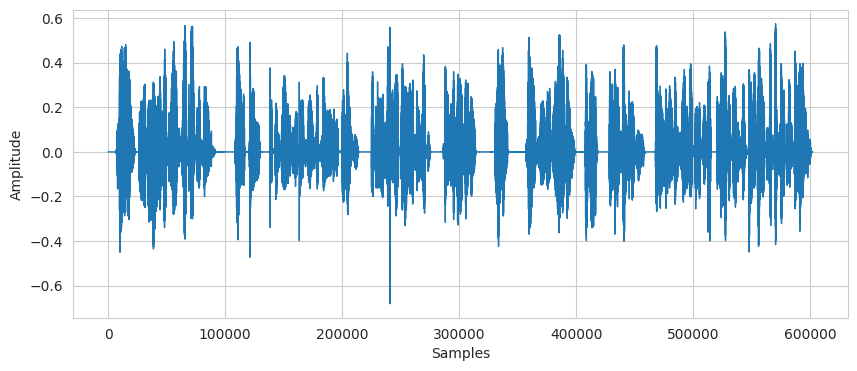

In [38]:
#audio_signal, sr = librosa.load("data/test.wav")

audio_signal = np.array(frames)
audio_signal = librosa.util.normalize(audio_signal)

plt.figure(figsize=(10, 4))
sns.lineplot(data=audio_signal, lw=1)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Spectrum

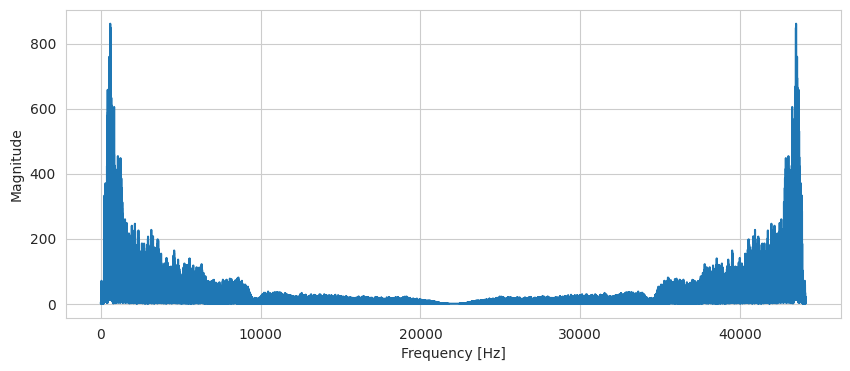

In [39]:
f_ratio = 1
     
fft_music = np.fft.fft(audio_signal)
fft_abs = np.absolute(fft_music)

plt.figure(figsize=(10, 4))

f = np.linspace(0, RATE, len(fft_abs))
f_bins = int(len(fft_abs)*f_ratio)

plt.plot(f[:f_bins], fft_abs[:f_bins])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.show()


### Mel Frequency Cepstral Coefficients (MFCC)

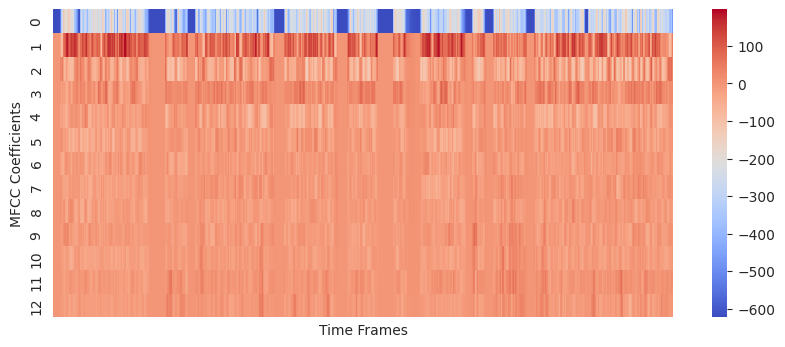

In [40]:
mfccs = librosa.feature.mfcc(y=audio_signal, sr=RATE, n_mfcc=13)

plt.figure(figsize=(10, 4))
sns.heatmap(mfccs, cmap='coolwarm', xticklabels=False, yticklabels=True)
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.show()

### GMM

[1, 2, 3]


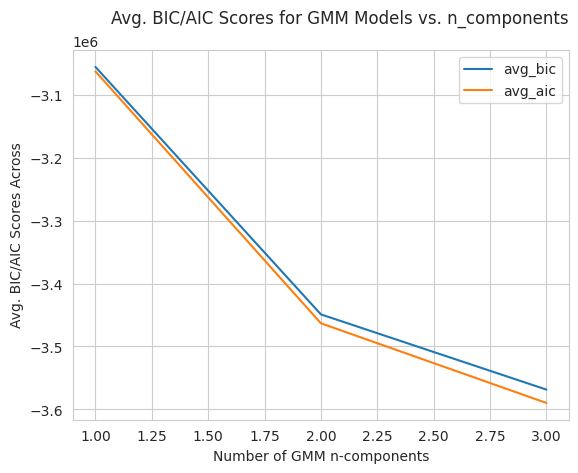

In [41]:
features = extract_aud_feat(audio_signal)
n_components = [1, 2, 3]

print(n_components)
bic_scores = []
aic_scores = []

for c in n_components:

    gmm_model = gmm(n_components=c)
    gmm_model.fit(features)

    bic_scores.append(gmm_model.bic(features))
    aic_scores.append(gmm_model.aic(features))

plt.plot(n_components, bic_scores)
plt.plot(n_components, aic_scores)
plt.title('Avg. BIC/AIC Scores for GMM Models vs. n_components', loc='right', y=1.05)
plt.xlabel('Number of GMM n-components')
plt.ylabel('Avg. BIC/AIC Scores Across')
plt.legend(['avg_bic', 'avg_aic'])
plt.show()


<Axes: ylabel='Count'>

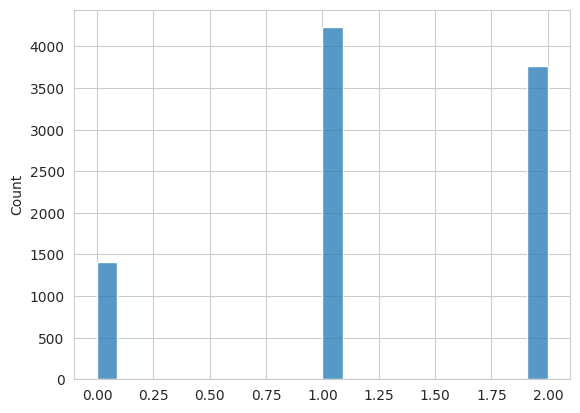

In [42]:
sns.histplot(gmm_model.predict(features))

<Axes: >

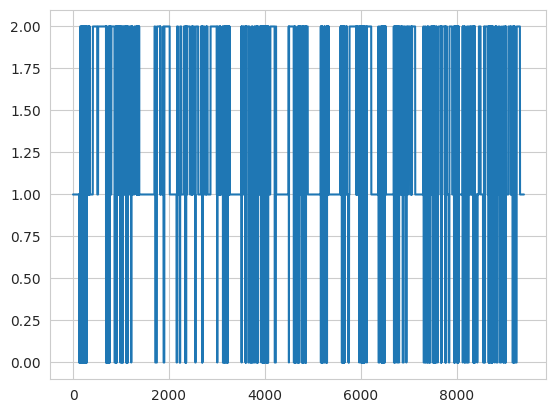

In [43]:
sns.lineplot(gmm_model.predict(features))

### Questions / Challenges

- Detect when someone is talking
- Filter out noise
- Detect the number of speakers and init cluster methods accordingly
- 